In [3]:
import matplotlib.pyplot as plt

from IPython.display import display

from tqdm import tqdm_notebook

import math
import numpy as np
import time

from PIL import Image

import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision.transforms as transforms

from warpctc_pytorch import CTCLoss

from lib.utilities import HYPERPARAMETERS, Metric, torch_weight_init, print_model_summary, DelayedKeyboardInterrupt, \
    plot_learning_curves, visualize_data, SequenceWise
from lib.vocabulary import Vocabulary
from lib.dataloader import DataArgumentation, FromNumpyToTensor, IAMHandwritingDataset, alignCollate, ResizeAndPad
from lib.checkpoint import Checkpoint
from lib.decoder import CTCGreedyDecoder
from lib.stopping import Stopping
from lib.logger import PytorchLogger, TensorboardLogger
from lib.spelling import Spelling
from lib.trainer import Trainer
from lib.evaluator import Evaluator
from lib.recognizer import Recognizer
from lib.scorer import Scorer, SpellingScorer, ScorerSM, ScorerLEV

import lib.model_seq as m


In [4]:
#torch.cuda.is_available = lambda : False
#torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = True


In [5]:
seed = 0
np.random.seed(0)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [6]:
H = HYPERPARAMETERS({
    'MODEL_PATH': 'chkpt/IAM_HTR_SEQ18.tar',
    'ROOT_DIR': './data',
    'EXPERIMENT': 'IAM_HTR_SEQ18',
    'BATCH_SIZE': 16,
    'HEIGHT': 64,
    'MAX_SEQ_LEN' : 93,
    'PADDING': 10,
    'NUM_WORKERS': 8,
    'ENCODER_HIDDEN_SIZE': 256,
    'DECODER_HIDDEN_SIZE': 512,
    'NUM_LAYERS': 2,
    'BIDIRECTIONAL': True,
    'RNN_DROPOUT': 0.5,
    'LR': 0.0003,
    'LR_LAMBDA': lambda epoch: max(math.pow(0.78, math.floor((1 + epoch) / 11.0)), 0.4),
    'WEIGHT_DECAY': 0,
    'MAX_GRAD_NORM': 5.,
    'ARGUMENTATION': 0.9,
    'STOPPING_PATIENCE': 10,
    'NUM_EPOCHS': 50,
    
    'CHECKPOINT_FILE': 'IAM_HTR_SEQ18',
    'CHECKPOINT_INTERVAL': 5,
    'CHECKPOINT_RESTORE': False,
    
    'USE_CUDA': torch.cuda.is_available(),
})

In [7]:
import os
import json

class Vocabulary(object):
    def __init__(self, root_dir, structure='lines', architecture="ctc"):
        self.root_dir = root_dir
        self.structure = structure         # 'lines', 'words'
        self.architecture = architecture   # 'ctc', 'seq'

        self.token2idx = {}
        self.idx2token = {}
        self.idx = 0
        self.path = os.path.join(self.root_dir, 'vocab_'+ self.structure + '.json')

        if self.architecture == 'ctc':
            self.add(chr(1)) # extra output dimension for the BLANK label required for CTC loss
        else:
            self.add(chr(0)) 
            
    def add(self, token):
        if not token in self.token2idx:
            self.token2idx[token] = self.idx
            self.idx2token[self.idx] = token
            self.idx += 1

    def __call__(self, val):
        res = None
        if isinstance(val, str):
            res = self.token2idx[val] if val in self.token2idx else self.token2idx['']
        elif isinstance(val, int):
            res = self.idx2token[val] if val <= self.__len__() else self.token2idx['']
        else:
            raise RuntimeError
        return res

    def __len__(self):
        return len(self.token2idx)

    def create(self, alphabet):
        for c in alphabet:
            self.add(c)

    def dump(self):
        data = {'idx': self.idx, 'token2idx':self.token2idx, 'idx2token':self.idx2token}
        with open(self.path, "w") as fd:
            json.dump(data, fd)

    def load(self):
        with open(self.path, "r") as fd:
            data = json.load(fd)
            self.idx = int(data['idx'])
            self.token2idx = data['token2idx']
            self.idx2token = {int(k):v for k,v in data['idx2token'].items()}
            
        if self.architecture == 'seq':
            self.add('<SOS>')
            self.add('<EOS>')
            self.add('<UNK>')

    def __repr__(self):
        return ''.join(list(self.token2idx.keys()))

In [8]:
vocab = Vocabulary("./data/IAM/", structure='lines', architecture="seq")
vocab.load()

vocab, len(vocab)

(  !"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz<SOS><EOS><UNK>,
 83)

In [9]:
def eos_parsing(sentence, vocab):
    IDX_EOS = vocab('<EOS>')
    if IDX_EOS in sentence:
        sentence = sentence[:sentence.index(IDX_EOS)]
    return sentence

def get_perplexity(loss):
    try:
        return math.pow(2, loss)
    except OverflowError:
        return float('inf')

In [10]:
encoder_pred = m.Encoder(H.ENCODER_HIDDEN_SIZE, n_layers=H.NUM_LAYERS, dropout=H.RNN_DROPOUT, 
                  bidirectional=H.BIDIRECTIONAL, initialize=torch_weight_init)
decoder_pred = m.Decoder(len(vocab), H.DECODER_HIDDEN_SIZE, H.ENCODER_HIDDEN_SIZE, len(vocab), 
                  n_layers=H.NUM_LAYERS, dropout=H.RNN_DROPOUT, initialize=torch_weight_init)
nhtr_pred = m.NeuralHandwrittenTextRecognizer(encoder_pred, decoder_pred, vocab, 
                                              H.MAX_SEQ_LEN, teacher_forcing_ratio=0.5)
if H.USE_CUDA:
    nhtr_pred.cuda()
    
state = torch.load(H.MODEL_PATH)
nhtr_pred.load_state_dict(state)

In [11]:
from kraken import pageseg
from kraken import binarization

def segmentation(image):

    img = binarization.nlbin(image, threshold=0.5, zoom=0.5, escale=1.0, border=0.1, perc=80, 
                                 range=20, low=5, high=90)

    res = pageseg.segment(img, text_direction='horizontal-lr', scale=None, 
                                   maxcolseps=2, black_colseps=False)
    return res

In [12]:
# import os

# image.save("/tmp/out.jpg", "JPEG")


# file = "/tmp/out.jpg"
# name = os.path.basename(file).split('.')[0]

# out_name = 'trans'
# out_dir = '/tmp/'

# command = "imgtxtenh -d 118.110 {0} {2}{1}.jpg".format(file, out_name, out_dir)
# errno = os.system(command)
# print(errno)


# # command = "imgtxtenh -d 118.110 {0} {1}{2}.jpg".format(file, name)
# # errno = os.system(command)
# # print(errno)

# # command = ("convert /tmp/{0}.png -deskew 40% \
# # -bordercolor white -border 5 -trim -bordercolor white -border 20x0 \
# # +repage -strip {1}{2}.jpg").format(name, out_dir, out_name)
# # errno = os.system(command)

# image = Image.open('/tmp/trans.jpg').convert('L')

In [13]:
import torch.utils.data as data

class IAMHandwritingDataset(data.Dataset):
    def __init__(self, root, name, transform=None):
        self.root = root
        self.name = name
        self.transform = transform
        
        path = os.path.join(root, name)
        image = Image.open(path).convert('L')
        self.image = image.crop([0, 670, image.size[0], image.size[1]-775])

        self.boxes = segmentation(self.image)['boxes']
        
    def __getitem__(self, index):
        image = self.image.crop(self.boxes[index])
                        
        if self.transform is not None:
            image = self.transform(image)

        return image

    def __len__(self):
        return len(self.boxes)
    
    def __repr__(self):
        fmt_str = self.__class__.__name__ + '\n'
        fmt_str += '    Image name: {}\n'.format(self.name)
        fmt_str += '    Image ROIs: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


In [14]:
class alignCollate(object):

    def __init__(self, img_height=32):
        self.img_height = img_height

    def __call__(self, batch):
        images = batch

        sizes = [(image.size(1),image.size(2)) for image in images]
        widths = [ int(float(s[1]) * (self.img_height / float(s[0]))) for s in sizes]
        max_width = max(max(widths), self.img_height)

        transform = transforms.Compose([
            transforms.ToPILImage(),
            ResizeAndPad(self.img_height, max_width),
            transforms.ToTensor()
        ])

        images = [transform(image) for image in images]
        images = torch.cat([t.unsqueeze(0) for t in images], 0)
        image_sizes = torch.IntTensor(widths)

        return images

In [15]:
image_transform = transforms.Compose([
    transforms.Pad((H.PADDING, H.PADDING, H.PADDING, H.PADDING), fill=255),
    transforms.ToTensor(),
])

In [16]:
root = 'data/IAM/imgs/forms/formsA-D/'
file = 'a01-058x.png'

dataset = IAMHandwritingDataset(root, file, image_transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=H.BATCH_SIZE, 
                                     shuffle=False, num_workers=H.NUM_WORKERS,
                                    collate_fn=alignCollate(img_height=H.HEIGHT))
dataset

IAMHandwritingDataset
    Image name: a01-058x.png
    Image ROIs: 10
    Root Location: data/IAM/imgs/forms/formsA-D/
    Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1d3cf4860>

In [17]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

input_vars = next(loader.__iter__())

print(input_vars.shape)

@interact(idx=(0, input_vars.size(0)-1))
def show(idx):
    print(input_vars[idx].shape)
    visualize_data(input_vars[idx], "", vocab, figsize=(18,8))

torch.Size([10, 1, 64, 722])


interactive(children=(IntSlider(value=4, description='idx', max=9), Output()), _dom_classes=('widget-interact',))

In [18]:
nhtr_pred.eval()
with torch.no_grad():
    idx_batch = 0
    lines = []
    for idx_batch, input_vars in enumerate(loader):
        input_vars = Variable(input_vars)
        if H.USE_CUDA:
            input_vars = input_vars.cuda()

        decoder_outputs = nhtr_pred(input_vars, None)

        batch_size = input_vars.size(0)

        output_seq = [[] for _ in range(batch_size)]
        for decoder_output in decoder_outputs:
            for batch_idx in range(batch_size):
                output_seq[batch_idx].append(decoder_output[batch_idx].topk(1)[1].item())

        for batch_idx in range(batch_size):
            output_seq[batch_idx] = eos_parsing(output_seq[batch_idx], vocab)
                    
        idx = 0
        for idx, dseq in enumerate(output_seq):
            dseq = ''.join([vocab(c) for c in dseq])
            lines.append( dseq)
                    
len(lines)

10

In [19]:
' '.join(lines)

"PRESIDENT KENNEDI is realy to get tough over not Germany's ask offer to # help Aneriea's talance of payments parition He said bluntly in Nashington yestedy that the offer - 357million - was not good enrugh . And he intiated that hat his Government would try toget Germany to pay more . He did not nextion perioul talks with Dr. Adenauer , the West ferman Chancelor ."

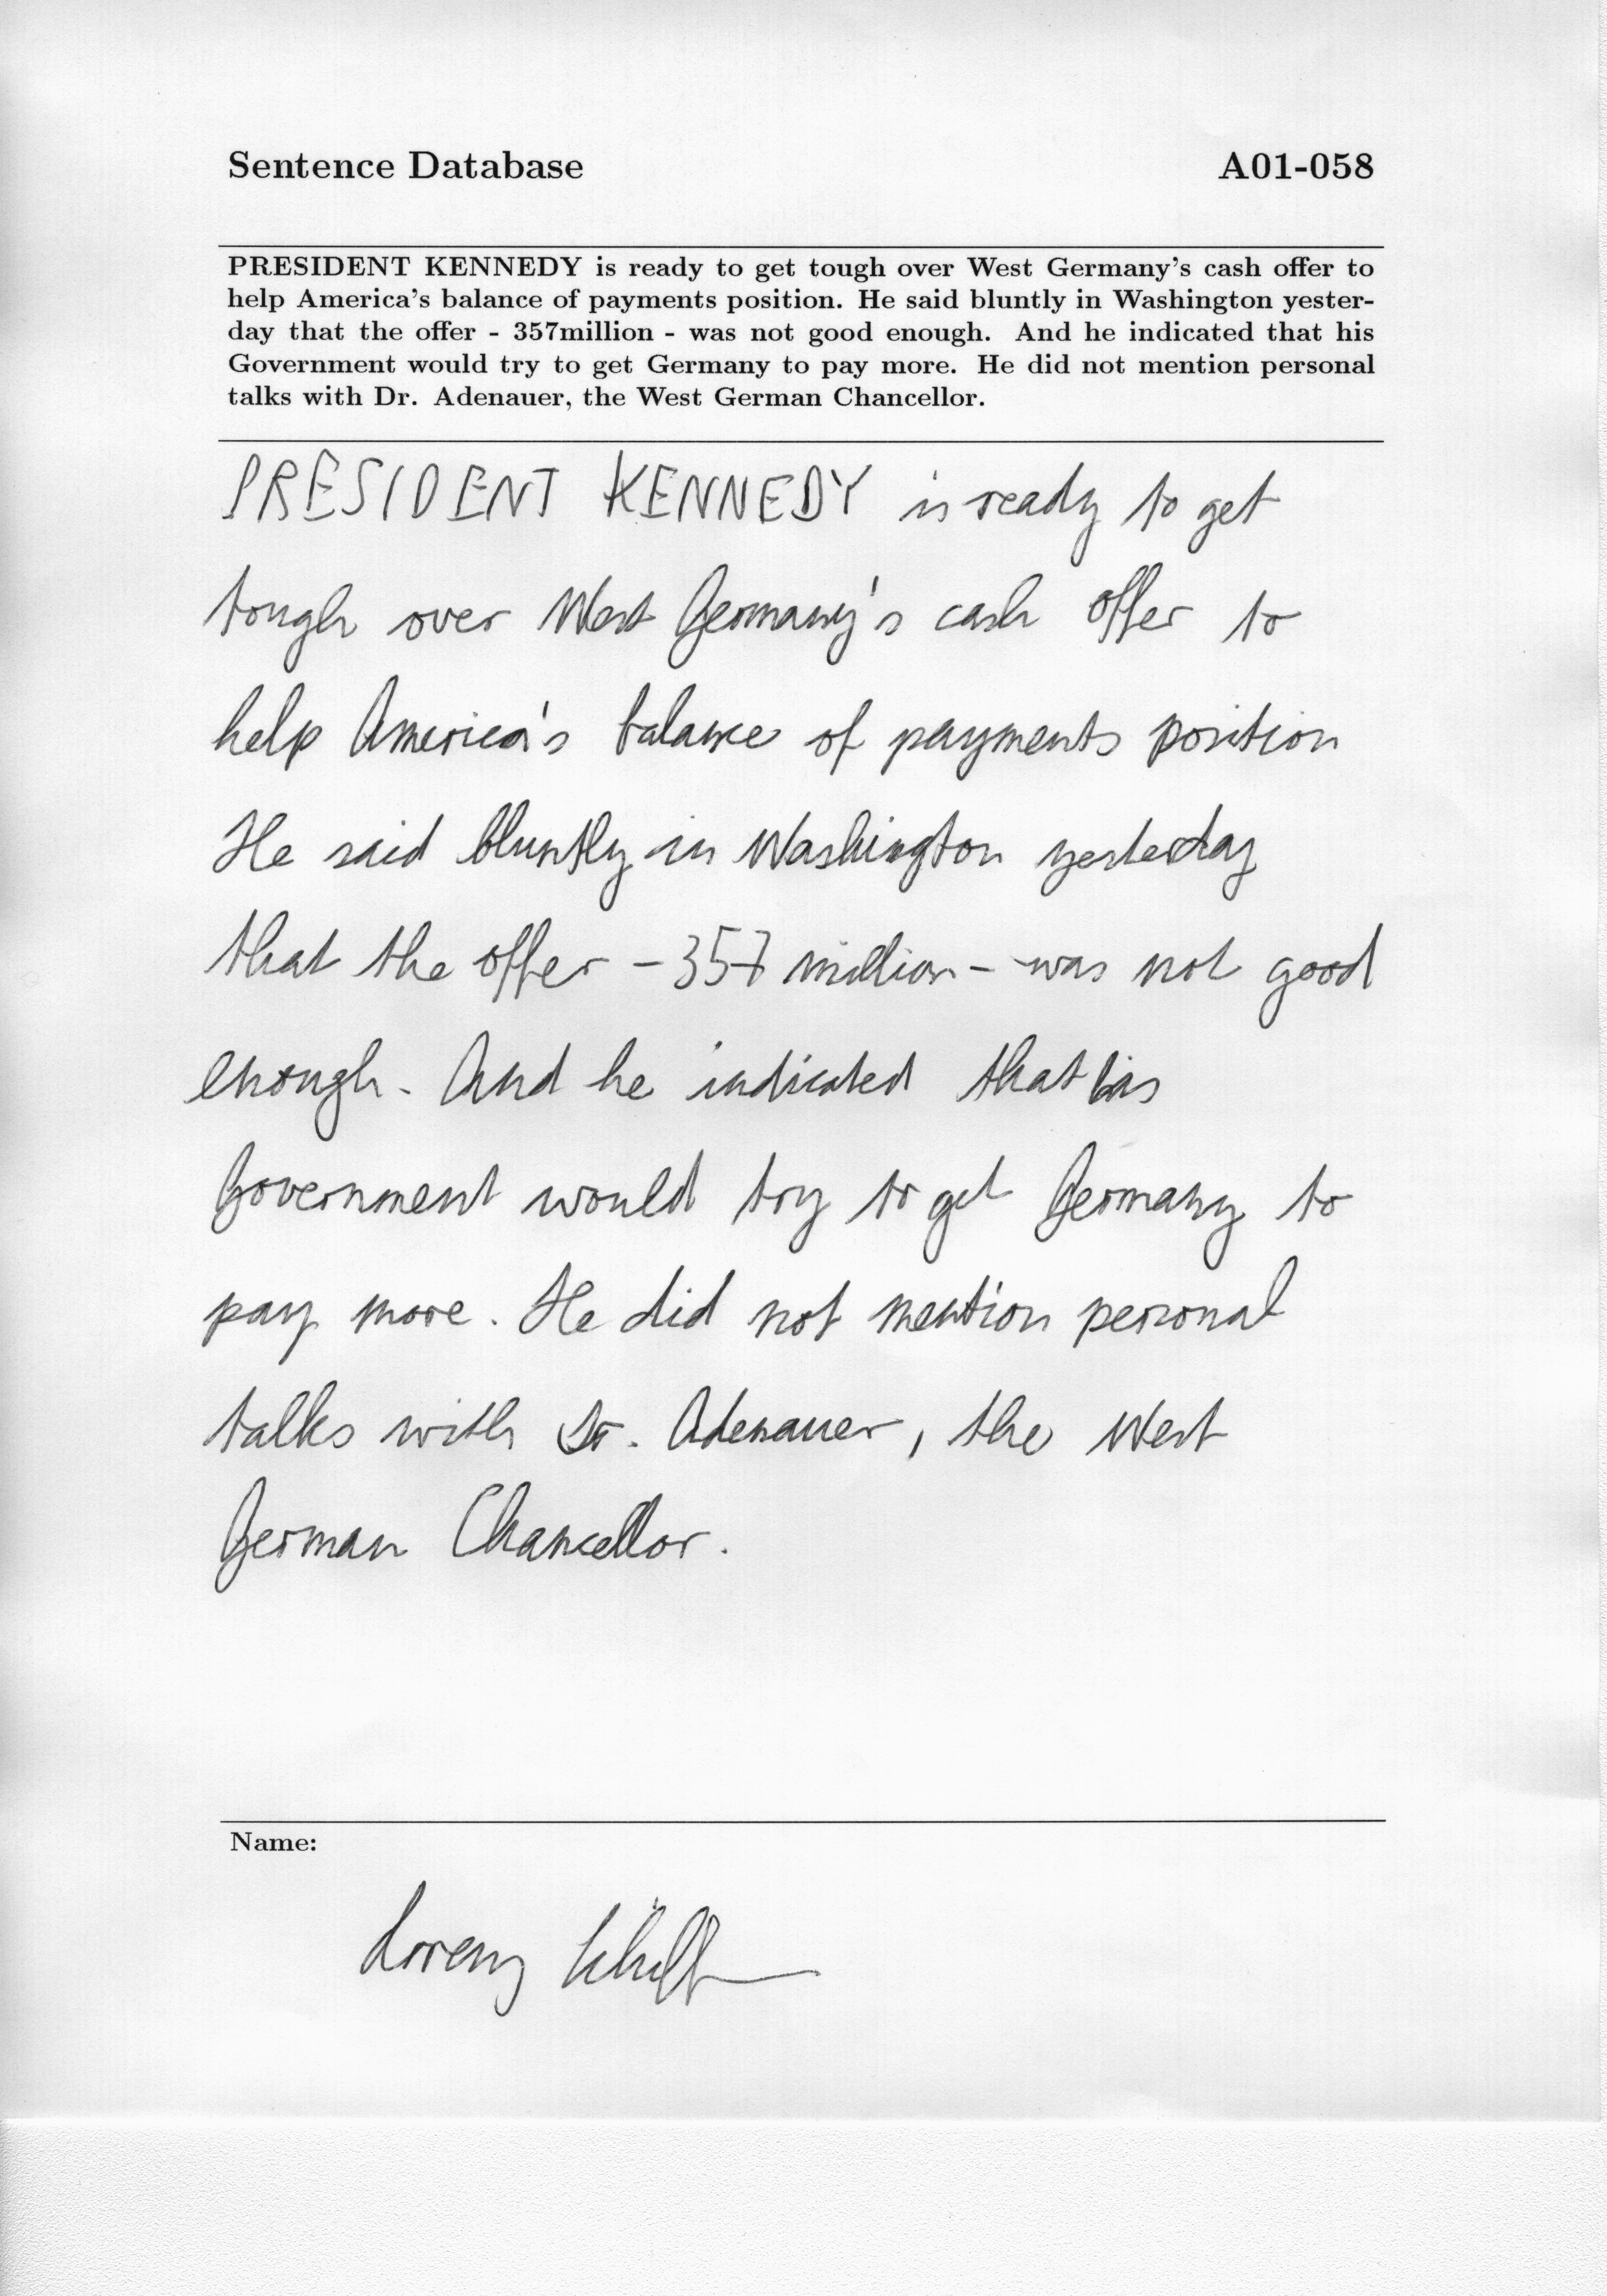

In [20]:
Image.open(os.path.join(root, file)).convert('L')